# Import Libraries and Data

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def load_data():

    data = pd.read_csv(r"/content/drive/MyDrive/Master Thesis Project/brics csv files/south_africa_data.csv")

    # Clean column names - strip whitespace
    data.columns = data.columns.str.strip()

    # Convert Year to datetime and set as index
    data['Year'] = pd.to_datetime(data['Year'].astype(str))
    data.set_index('Year', inplace=True)
    data.index = data.index + pd.offsets.YearEnd(0)

    # Scale GDP to trillions for better numerical stability
    data['GDP'] = data['GDP'] / 1e12

    # Clean column names
    data = data.rename(columns={'Urban population growth': 'Urban_Growth'})
    data = data.rename(columns={'PPP conversion factor GDP (LCU per International $)': 'PPP'})
    data = data.rename(columns={'GDP per capita PPP (current international $)': 'GDP_PPP'})


    return data

# Feature Engineering

In [ ]:
def create_features(data):

    df = data.copy()

    # Economic features
    df['GDP_lag1'] = df['GDP'].shift(1)
    df['GDP_ma3'] = df['GDP'].rolling(window=3).mean()
    df['GDP_growth'] = df['GDP'].pct_change()

    # Trade features
    df['Trade_ma3'] = df['Trade'].rolling(window=3).mean()
    df['Trade_growth'] = df['Trade'].pct_change()

    # Population features
    df['Population_growth'] = df['Population'].pct_change()
    df['Population_ma3'] = df['Population'].rolling(window=3).mean()

    # Additional features
    df['GDP_per_capita'] = df['GDP'] * 1e12 / df['Population']
    df['GDP_per_capita_growth'] = df['GDP_per_capita'].pct_change()

    # External shock variables
    # 1991: Economic liberalization reforms
    # df['liberalization'] = 0
    # df.loc[df.index.isin([1991]), 'liberalization'] = 1

    # # 2008: Global financial crisis shock
    # df['GFC'] = 0
    # df.loc[df.index.isin([2008, 2009]), 'GFC'] = 1

    # # 2016: Demonetization shock
    # df['demonetization'] = 0
    # df.loc[df.index.isin([2016, 2017]), 'demonetization'] = 1

    # # 1994: End of apartheid shock
    df['post_apartheid'] = 0
    df.loc[df.index.isin([1990,1995]), 'post_apartheid'] = 1

    # 2008: Commodity price fluctuations shock
    df['commodity_fluctuations'] = 0
    df.loc[df.index.isin([2001,2008]), 'commodity_fluctuations'] = 1

    # 2015: Political uncertainty shock
    df['political_uncertainty'] = 0
    df.loc[df.index.isin([2010,2017]), 'political_uncertainty'] = 1

    # 2020: COVID-19 pandemic shock
    df['COVID'] = 0
    df.loc[df.index.isin([2020,2021]), 'COVID'] = 1

    return df.dropna()

# Model training and evaluation

Loading data...
Data loaded successfully
Creating features...
Features created successfully


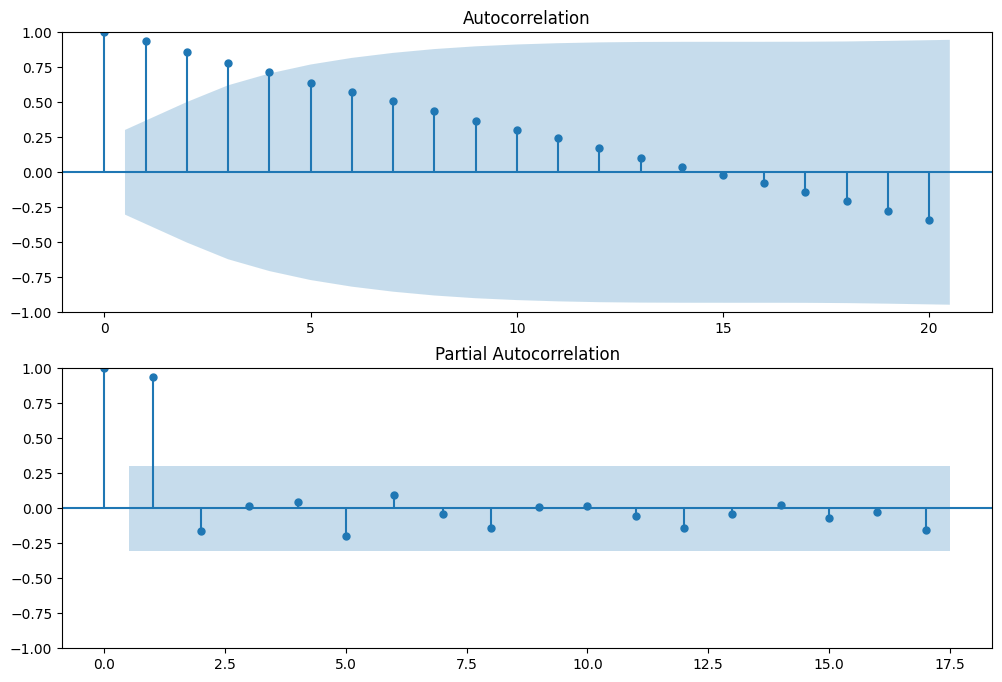

Fitting SARIMAX model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitted successfully
AIC: -97.83
BIC: -73.46
Test RMSE: 0.03
Test MSE: 0.0011
Test MAE: 0.02
Generating forecasts...


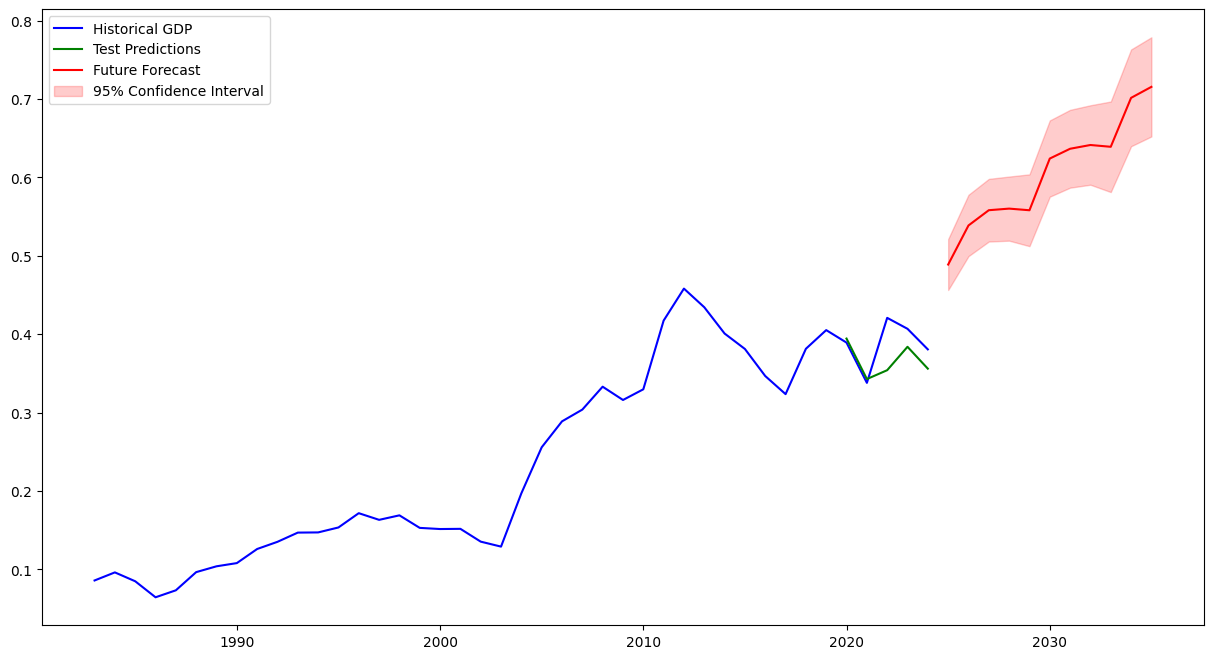


GDP Forecasts (Trillions USD):
2024: $0.49
2025: $0.54
2026: $0.56
2027: $0.56
2028: $0.56
2029: $0.62
2030: $0.64
2031: $0.64
2032: $0.64
2033: $0.70
2034: $0.72


In [ ]:
def main():
    # Load and prepare data
    print("Loading data...")
    data = load_data()
    print("Data loaded successfully")

    # Create features
    print("Creating features...")
    df = create_features(data)
    print("Features created successfully")

    # Plot ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df['GDP'], lags=20, ax=axes[0])
    plot_pacf(df['GDP'], lags=17, ax=axes[1])
    plt.show()

    # Define exogenous variables
    exog_vars = ['Trade', 'Urban_Growth', 'Trade_ma3', 'GDP_lag1', 'GDP_ma3',
             'Population_growth', 'Population_ma3', 'GDP_per_capita_growth','GDP_PPP',
             'COVID', 'post_apartheid', 'commodity_fluctuations', 'political_uncertainty']

    # Split data: Train up to 2018, test from 2019 onward
    train = df.loc[:'2018']
    test = df.loc['2019':]

    # Fit model
    print("Fitting SARIMAX model...")
    model = SARIMAX(
    train['GDP'],
    exog=train[exog_vars],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 4),
    enforce_stationarity=False)
    results = model.fit(disp=False)
    print("Model fitted successfully")

    # Calculate AIC and BIC
    aic = results.aic
    bic = results.bic
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")

    # Make predictions
    test_forecast = results.get_forecast(steps=len(test), exog=test[exog_vars])
    test_pred = test_forecast.predicted_mean

    # Calculate evaluation metrics
    mse = mean_squared_error(test['GDP'], test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test['GDP'], test_pred)
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.2f}")

    results_updated = results.append(endog=test['GDP'], exog=test[exog_vars], refit=False)

    forecast_steps = 11

    # Generate future exogenous variables
    last_data = df.iloc[-forecast_steps:]
    future_index = pd.date_range(
        start="2024-01-01",
        periods=forecast_steps,
        freq='YE'
    )

    # Project exogenous variables
    future_exog = pd.DataFrame(index=future_index)
    future_exog['Trade'] = last_data['Trade'].mean()
    future_exog['Urban_Growth'] = last_data['Urban_Growth'].mean()
    future_exog['Trade_ma3'] = last_data['Trade_ma3'].mean()
    future_exog['GDP_lag1'] = df['GDP'].iloc[-1]
    future_exog['GDP_ma3'] = df['GDP_ma3'].iloc[-1]
    future_exog['Population_growth'] = last_data['Population_growth'].mean()
    future_exog['Population_ma3'] = last_data['Population_ma3'].mean()
    future_exog['GDP_per_capita_growth'] = last_data['GDP_per_capita_growth'].mean()
    future_exog['GDP_PPP'] = last_data['GDP_PPP'].mean()
    future_exog['COVID'] = 0
    future_exog['post_apartheid'] = 0
    future_exog['commodity_fluctuations'] = 0
    future_exog['political_uncertainty'] = 0

    # Generate forecasts
    print("Generating forecasts...")
    future_forecast = results_updated.get_forecast(steps=forecast_steps, exog=future_exog[exog_vars])
    forecast_mean = future_forecast.predicted_mean
    forecast_ci = future_forecast.conf_int()

    # Plot test results
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df['GDP'], label='Historical GDP', color='blue')
    plt.plot(test.index, test_pred, label='Test Predictions', color='green')


    #Plot future forecast using the new index
    plt.plot(future_forecast.predicted_mean.index, forecast_mean, label='Future Forecast', color='red')
    plt.fill_between(
        future_forecast.predicted_mean.index,
        forecast_ci.iloc[:, 0],
        forecast_ci.iloc[:, 1],
        color='red', alpha=0.2, label='95% Confidence Interval'
    )
    plt.legend()
    plt.show()


    # Print forecasts
    print("\nGDP Forecasts (Trillions USD):")
    for year, gdp in zip(future_forecast.predicted_mean.index.year, forecast_mean):
        print(f"{year}: ${gdp:,.2f}")

if __name__ == "__main__":
    main()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
